Redes Neuronales Convolucionales
=
Clasificación de imágenes de bananos según su estado de madurez.
Aplicaciones en su cosecha, selección y distribución.

### Definir la red

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Red(nn.Module):

    def __init__(self):
        super(Red, self).__init__()
        # imagen de 3 canales (RGB), 6 canales de salida, dimensiones de 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # calcular total de parámetros por imagen: y = Wx + b
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6) # 6 clases de salida

    # operaciones
    def forward(self, entrada):
        # Capa convolucional C1: recibe 1 imagen de 3 canales (RGB), produce 6 canales de salida, de dimensión 5x5 con activación ReLU
        # y genera un tensor de tamaño (N, 6, 224, 224), donde N es el batch
        c1 = F.relu(self.conv1(entrada))
        # Capa de subsampling S2: max-pooling 2x2, sin parámetros, salida (N, 6, 14, 14), donde N es el batch
        s2 = F.max_pool2d(c1, (2, 2))
        # Capa convolucional C3: 6 canales de entrada, 16 de salida, dimensión de 5x5 con activación ReLU salidas a Tensor de (N, 16, 10, 10)
        c3 = F.relu(self.conv2(s2))
        # Capa de subsampling S4: max-pooling 2x2, sin parámetros, salida (N, 16, 53, 53), donde N es el batch
        s4 = F.max_pool2d(c3, 2)
        #print("Salidas y dimensiones:",s4.shape)
        # Operación Flatten: sin parámetros, salida (44944), donde N es el batch
        s4 = torch.flatten(s4, 1)
        # Capa totalmente conectada F5: entrada (44944), salida (120) con activación ReLU
        f5 = F.relu(self.fc1(s4))
        # Capa totalmente conectada F6: entrada (120), salida (84) con activación ReLU
        f6 = F.relu(self.fc2(f5))
        # Capa de salida (F7): entrada (84), salida (6) -> capa de clasificación
        salida = self.fc3(f6)

        return salida


red = Red()
print(red)

Red(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


### Cargar dataset
En esta sección se carga todo el dataset de imágenes que se van a utilizar para entrenar, validar y probar el modelo.

In [ ]:
# cargar dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import zipfile
import shutil
import os

# descomprimir dataset
ruta = "../content/Banana_Ripeness"
rutas = [os.path.join(ruta, "train"), os.path.join(ruta, "test")]
with zipfile.ZipFile(ruta+".zip", 'r') as zip_ref:
        zip_ref.extractall(ruta)

# transformar a tensor y normalizar dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 32
# entrenamiento (70%)
training_data = datasets.ImageFolder(
    root=rutas[0],
    transform=transform
)
# test (15%)
test_data = datasets.ImageFolder(
    root=rutas[1],
    transform=transform
)

# tamaño de test
n_test = len(test_data)

# dividir train en validación (15%)
indices = list(range(len(training_data)))
train_indices, val_indices = train_test_split(indices, test_size=n_test, random_state=42, shuffle=True)

#dividir train y val
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

# crear variables para datos de entrenamiento, validación y pruebas / DATALOADERS
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

print("Datos de entrenamiento:",len(train_data))
print("Datos de validación:",len(val_data))
print("Datos de prueba:",len(test_data))
print("Datos totales:",len(train_data)+len(test_data)+len(val_data))
# obtener clases
clases=('freshripe','freshunripe','unripe','overripe','ripe','rotten')
print("Clases:",clases)

Datos de entrenamiento: 16332
Datos de validación: 3501
Datos de prueba: 3501
Datos totales: 23334
Clases: ('freshripe', 'freshunripe', 'unripe', 'overripe', 'ripe', 'rotten')


### Obtener caractertisticas y etiquetas de las imágenes

In [ ]:
#obtener caracteristicas de imagenes y etiquetas
train_features, train_labels = next(iter(train_dataloader))
print(f"Tamaño de lote, canales y dimensiones: {train_features.size()}")
print(f"Número de etiquetas por cada lote: {train_labels.size()}")

Tamaño de lote, canales y dimensiones: torch.Size([32, 3, 224, 224])
Número de etiquetas por cada lote: torch.Size([32])


### Definir función de pérdida y optimizador
Mediante está función se optimiza el proceso de aprendizaje de la red a través de la Gradiente Descendente

In [ ]:
import torch.optim as optim

criterio = nn.CrossEntropyLoss()
# momentum sirve para acelerar el proceso de encontrar el valor más cercano a cero
optimizador = optim.SGD(red.parameters(), lr=0.001, momentum=0.9)
print(optimizador)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Configurar uso de GPU
Buscar dispositivo (GPU) disponible para acelerar entrenamiento

In [ ]:
# elección de arquitectura
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando:",device)

# Mover el modelo a GPU/CPU
red.to(device)

Usando: cuda


Red(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

### Entrenamiento de la CNN
Entrenamiento de la CNN mediante el uso del datos de entrenamiento en un número específico de épocas, dónde por cada una de estas se busca y actualiza el mejor modelo según la pérdida con los datos de validación.

In [ ]:
# Entrenamiento de modelo
mejor_modelo = None
menor_perdida = float("inf")
m_epoca = 0
train_perdida = []
train_precision = []

for epoca in range(20):  # número de épocas
    red.train() # entrenamiento
    running_loss = 0.0
    for entradas, etiquetas in train_dataloader:
        # mover datos a GPU/CPU
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        # gradiente de ceros
        optimizador.zero_grad()

        # forward + backward + optimize = backpropagation = propagación hacia atrás
        salidas = red(entradas) # envío
        perdida = criterio(salidas, etiquetas) # calculo diferencia o pérdida
        perdida.backward() # Actualiza pesos
        optimizador.step() # optimizo
        running_loss += perdida.item() # perdida acumulada

    # pérdida promedio por época
    perdida_promedio = running_loss / len(train_dataloader)
    print(f"[Epoca {epoca+1} | perdida promedio: {perdida_promedio:.3f}]")

    # validación
    red.eval()
    correcto, total, val_perdida = 0, 0, 0.0
    with torch.no_grad(): # no se usa gradiente
      for entradas, etiquetas in val_dataloader:
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        salidas = red(entradas)
        perdida_val = criterio(salidas, etiquetas)
        val_perdida += perdida_val.item()
        _, pred = torch.max(salidas, 1)
        total += etiquetas.size(0)
        correcto += (pred == etiquetas).sum().item()

    # perdida y ganancia por época
    val_perdida /= len(val_dataloader)
    val_acc = 100 * correcto / total
    train_precision.append(val_acc)
    print(f"Validación -> Precision {val_acc:0.2f}% | Pérdida {val_perdida:0.2f}")

 # guardar mejor modelo
    if val_perdida < menor_perdida:
        menor_perdida = val_perdida
        m_epoca = epoca+1
        mejor_modelo = red.state_dict()
    # almacenar perdidas en train_perdida
    train_perdida.append(perdida_promedio)
print('='*60)
print(f"Modelo con menor perdida: {menor_perdida:0.5f}, Epoca {m_epoca}")
print('Entrenamiento finalizado')

[Epoca 1 | perdida promedio: 1.494]
Validación -> Precision 51.64% | Pérdida 1.17
[Epoca 2 | perdida promedio: 1.016]
Validación -> Precision 66.07% | Pérdida 0.87
[Epoca 3 | perdida promedio: 0.834]
Validación -> Precision 71.18% | Pérdida 0.76
[Epoca 4 | perdida promedio: 0.726]
Validación -> Precision 71.98% | Pérdida 0.71
[Epoca 5 | perdida promedio: 0.658]
Validación -> Precision 74.04% | Pérdida 0.67
[Epoca 6 | perdida promedio: 0.590]
Validación -> Precision 74.49% | Pérdida 0.65
[Epoca 7 | perdida promedio: 0.542]
Validación -> Precision 75.24% | Pérdida 0.65
[Epoca 8 | perdida promedio: 0.475]
Validación -> Precision 77.21% | Pérdida 0.61
[Epoca 9 | perdida promedio: 0.431]
Validación -> Precision 72.15% | Pérdida 0.74
[Epoca 10 | perdida promedio: 0.381]
Validación -> Precision 74.29% | Pérdida 0.69
[Epoca 11 | perdida promedio: 0.337]
Validación -> Precision 74.89% | Pérdida 0.67
[Epoca 12 | perdida promedio: 0.274]
Validación -> Precision 76.06% | Pérdida 0.68
[Epoca 13 | p

### Guardar mejor modelo

In [ ]:
ruta = './mejor_modelo_banana.pth'
torch.save(mejor_modelo, ruta)

### Cargar modelo entrenado

In [ ]:
red = Red()
red.load_state_dict(torch.load(ruta, weights_only=True))
red.to(device)
red.eval() # evaluar modelo
print("Modelo cargado")

Modelo cargado


### Probar modelo
En esta sección se prueba el modelo con el fin de conocer la generalización de este ante los datos de test o prueba, y por ende calcular la precisión de este por cada clase.



In [ ]:
# Prueba de modelo por cada clase
aciertos_clase = {classname: 0 for classname in clases}
total_pred_clase = {classname: 0 for classname in clases}

# no se necesita la gradiente ya que se entrena una sola vez
with torch.no_grad():
    for entradas, etiquetas in test_dataloader:
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        salidas = red(entradas)
        _, predicciones = torch.max(salidas, 1)
        # collección de predicciones correctas por cada clase
        for etiqueta, prediccion in zip(etiquetas, predicciones):
            if etiqueta == prediccion:
                aciertos_clase[clases[etiqueta]] += 1
            total_pred_clase[clases[etiqueta]] += 1


# mostrar precision por cada clase
for n_clase, conteo_correctas in aciertos_clase.items():
    accuracy = 100 * float(conteo_correctas) / total_pred_clase[n_clase]
    print(f'Accuracy por clase: {n_clase:5s} es {accuracy:.2f} %')

Accuracy por clase: freshripe es 73.27 %
Accuracy por clase: freshunripe es 76.25 %
Accuracy por clase: unripe es 85.26 %
Accuracy por clase: overripe es 81.41 %
Accuracy por clase: ripe  es 77.79 %
Accuracy por clase: rotten es 81.31 %


### Precisión total
En esta sección se calcula la precisión total del modelo para clasificar todas las clases de madurez de banano.

In [ ]:
# calcular precisión en test
correcto = 0
total = 0
# no se necesita la gradiente
with torch.no_grad():
    for entradas, etiquetas in test_dataloader:
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        # calculate outputs by running images through the network
        salidas = red(entradas)
        # the class with the highest energy is what we choose as prediction
        _, prediccion = torch.max(salidas, 1)
        total += etiquetas.size(0)
        correcto += (prediccion == etiquetas).sum().item()
print(f'Accuracy de la red con {len(test_data)} imagenes de test: {100 * correcto / total:.2f} %')

Accuracy de la red con 3501 imagenes de test: 79.15 %


### Visualización de resultados
En esta sección se muestra la curvas tanto de pérdida como la curva de precisón en entrenamiento.

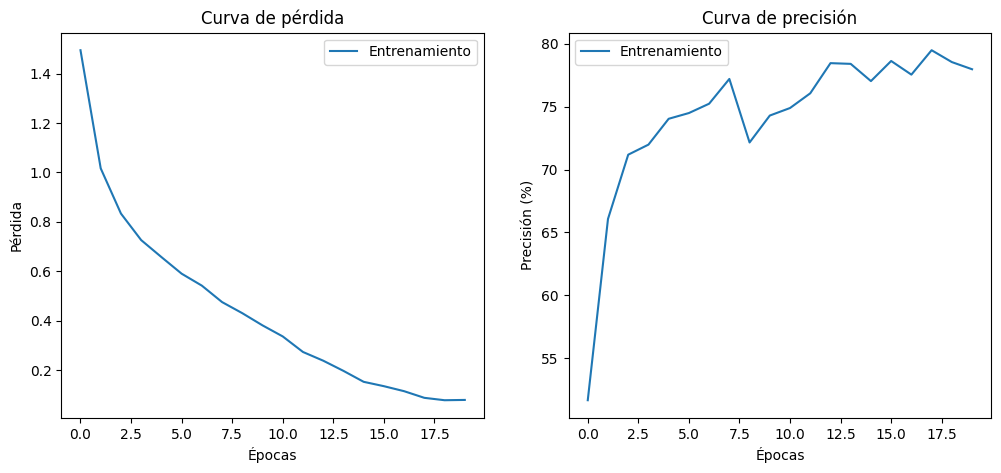

In [ ]:
import matplotlib.pyplot as plt

# Curva de pérdida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_perdida, label='Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()

# Curva de precisión
plt.subplot(1,2,2)
plt.plot(train_precision, label='Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Curva de precisión')
plt.legend()

plt.show()

### Mostrar imágenes

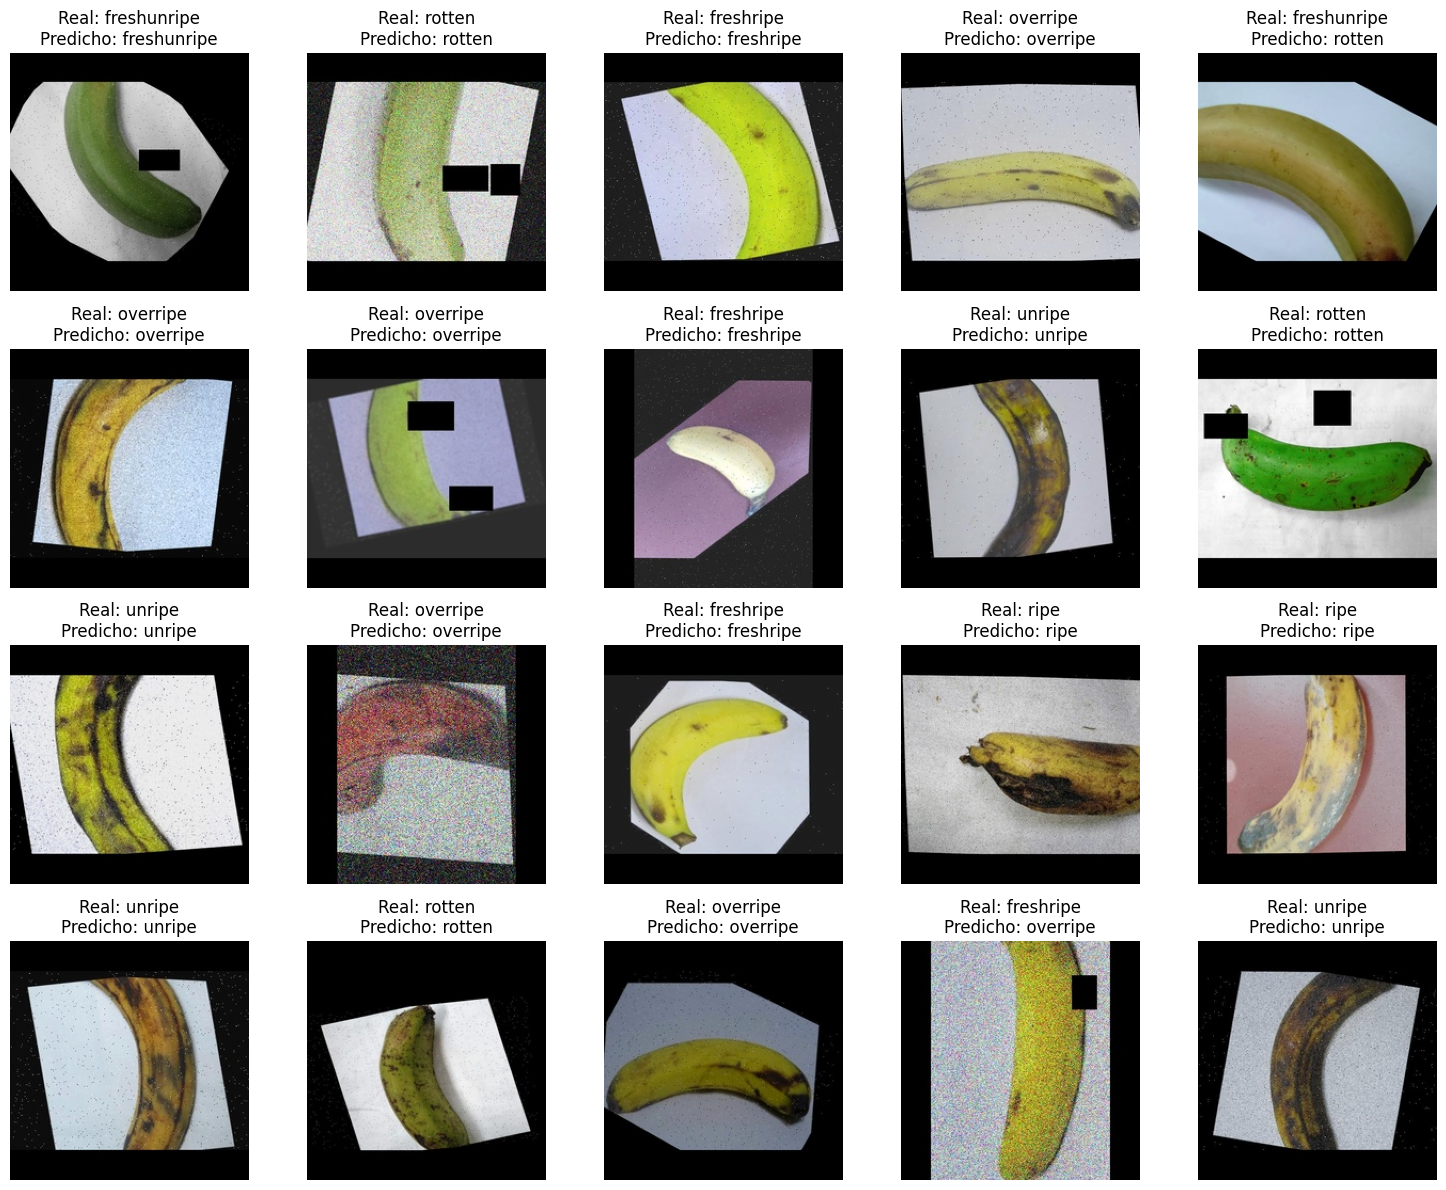

In [ ]:
import math
import matplotlib.pyplot as plt

def mostrar_imagen(img, etiqueta_real, etiqueta_pred):
    # Reordenar canales de [Canal,Alto,Ancho] a [Alto,Ancho,Canal]
    img = img.permute(1, 2, 0)
    # Desnormalizar (0.5,...),(0.5,...)
    img = img * 0.5 + 0.5
    img = img.cpu().numpy() # mover a cpu
    plt.imshow(img)
    plt.title(f"Real: {clases[etiqueta_real]}\nPredicho: {clases[etiqueta_pred]}")
    plt.axis("off")

def mostrar_imagenes(imagenes, etiquetas, predicciones, n=12):
    filas = math.ceil(n / 5)   # hasta 5 columnas por fila
    cols = min(n, 5)
    plt.figure(figsize=(cols*3, filas*3))
    for i in range(n):
        plt.subplot(filas, cols, i+1)
        mostrar_imagen(imagenes[i], etiquetas[i].item(), predicciones[i].item())
    plt.tight_layout()
    plt.show()

# Ejemplo: mostrar 20 imágenes
dataiter = iter(test_dataloader)
imagenes, etiquetas = next(dataiter)
# mover a GPU
imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
salidas = red(imagenes)
_, predicciones = torch.max(salidas, 1)

mostrar_imagenes(imagenes, etiquetas, predicciones, n=20)